# Data processing in Python - Final Project
# "Spatial Autocorrelation in Regional Covid Incidence 2020-2021"
### Heriberto Castilla, Jan Provazník

### DATA INTERPRETER
This project takes daily and weekly data from European countries on Covid-19 incidence rate per 100,000 people. We use this data together with a Shapefile to visualize the information on Covid incidence over time. The Shapefiles we use contain spatial information that allows us to plot the data by countries and regions. Having taken these two steps, furthermore the research question of our project asks whether spatial autocorrelation exists as a determining factor in the Covid-19 incidence rate over time. To do this we create weight matrix to calculate and visualize Moran's I as a time series.

## Import libraries and packages

In [36]:
import pandas as pd
import geopandas as gpd
import gdal
import shapely
import matplotlib.pyplot as plt
import descartes
import numpy as np
import pycountry
import esda
import libpysal as lps
import os
import gc
import imageio
import contextily
import rioxarray
import seaborn
from pysal.lib import cg as geometry

## Define class

In [20]:
# get country code for a given country name. If country code not found, extract it from the first two letters of the Nuts ID
def get_country_code(name, nuts_id):
    country = pycountry.countries.get(alpha_2=name)
    if not country:
        country = nuts_id[:2]
    return country

def plot_color_map(shapefile, country_data, week, use_min_max=False):
    merged = shapefile.set_index('NUTS_ID').join(country_data)
    # create figure and axes for plot
    fig, ax = plt.subplots(1, figsize=(10, 6))
    if use_min_max:
        # set the min and max of the data so that the colors are consistent over time
        vmin, vmax = country_data.min().min(), country_data.max().max()
        # Plot the given week with the darker red representing more cases and lighter reds representing lower cases per region
        merged.plot(column=week, cmap='RdYlGn_r', linewidth=1.0, ax=ax, edgecolor='1.0', vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    else:
        merged.plot(column=week, cmap='RdYlGn_r', linewidth=1.0, ax=ax, edgecolor='1.0', legend=True)

class Country:
    
    '''
    Country class created to store all necessary information (name, nuts_id, covid data, shapefile data, country code)
    in order to make it easier to plot for subsequent countries.
    
    '''
    

    def __init__(self, name, df):
        
        '''
        Initialize the country object from a name and dataframe provided. Store the country code, name, data and pivoted data.
        '''
        self.name = name
        # Pivot data so that the columns are the nuts_code while the rows are the covid cases
        nuts_code = df['nuts_code'].iloc[0]
        self.code = get_country_code(name, nuts_code)
        self.df = df.pivot(index='year_week', columns='nuts_code', values='rate_14_day_per_100k')
        self.shapefile = None
        # Pivot data so that index = nuts_code and columns = cases per year_week
        self.df_nuts_index = df.pivot(index='nuts_code', columns='year_week', values='rate_14_day_per_100k')

    def plot(self):
        self.df.plot()

    def set_shapefile(self, shapefile):
        self.shapefile = shapefile

    def plot_map(self):
        if self.shapefile:
            self.shapefile.plot(figsize=(14, 15))
            plt.show()

    # Inputs a week and plots a color map.
    def plot_country_color_map(self, week):
        country_data = self.df_nuts_index
        plot_color_map(self.shapefile, country_data, week)

## 1 Load data

In [21]:
# Data was downloaded from the following url https://opendata.ecdc.europa.eu/covid19/subnationalcaseweekly/csv
# Load the weekly data
weekly = pd.read_csv("covid_weekly_data.csv", sep=',').fillna(0)

# Load the daily data from downloaded file
daily = pd.read_csv("covid_daily_data.csv", sep=',').fillna(0)

In [22]:
weekly.head()

,country,region_name,nuts_code,year_week,rate_14_day_per_100k,source
0,Austria,Burgenland,AT11,2020-13,0.000000,"Epidemic intelligence, subnational weekly data"
1,Austria,Burgenland,AT11,2020-14,57.397873,"Epidemic intelligence, subnational weekly data"
2,Austria,Burgenland,AT11,2020-15,31.925444,"Epidemic intelligence, subnational weekly data"
3,Austria,Burgenland,AT11,2020-16,23.774267,"Epidemic intelligence, subnational weekly data"
4,Austria,Burgenland,AT11,2020-17,15.962722,"Epidemic intelligence, subnational weekly data"


In [23]:
weekly['country'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden'], dtype=object)

## 2 Visualize data

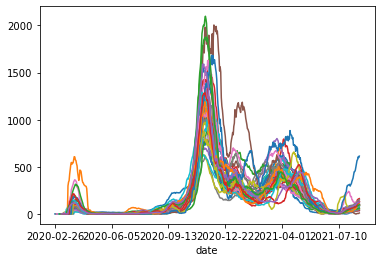

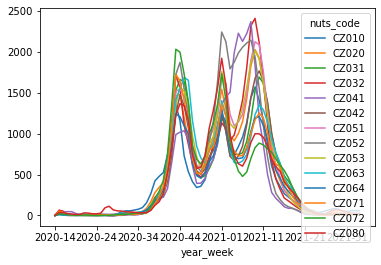

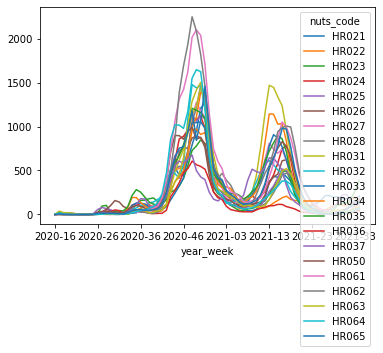

In [24]:
# Slice data from Austrian regions as an example
daily_au = daily.loc[daily['country'] == 'Austria']
daily_au = daily_au.pivot(index='date', columns='nuts_code', values='rate_14_day_per_100k')
daily_au.plot(legend=False)

# Slice data from Czech regions as an example
weekly_cz = weekly.loc[weekly['country'] == 'Czechia']
weekly_cz = weekly_cz.pivot(index='year_week', columns='nuts_code', values='rate_14_day_per_100k')
weekly_cz.plot()

# Pivot data so that index = nuts_code and columns = cases per year_week
nuts_code_index = weekly.pivot(index='nuts_code', columns='year_week', values='rate_14_day_per_100k')

# Create dictionary that maps from country code to Country() object
countries = {}

# Store all countries in weekly dataset with their own dataframe separately
for country in weekly['country'].unique():
    df = weekly.loc[weekly['country'] == country]
    country = Country(country, df)
    countries[country.code] = country

# As an example, plot Croatia's covid cases, with a line for each region
countries['HR'].plot()

## 3 Load shapefile

In [38]:
NUTS0 = gpd.read_file('NUTS0')
NUTS1 = gpd.read_file('NUTS1')
NUTS2 = gpd.read_file('NUTS2')
NUTS3 = gpd.read_file('NUTS3')

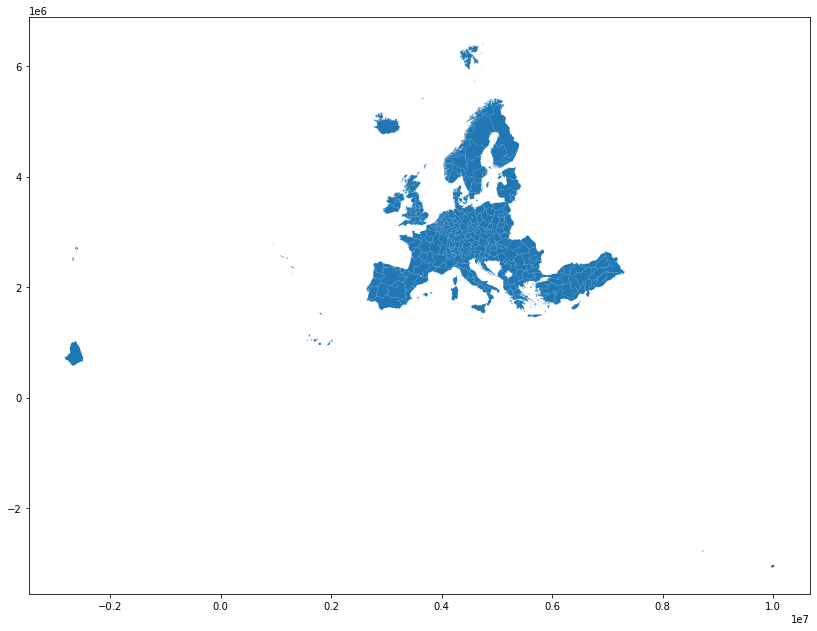

In [39]:
NUTS2.plot(figsize=(14, 15))
plt.show()

In [40]:
NUTS0_sub = NUTS0[NUTS0['FID'].isin(weekly['nuts_code'].unique())]
NUTS1_sub = NUTS1[NUTS1['FID'].isin(weekly['nuts_code'].unique())]
NUTS2_sub = NUTS2[NUTS2['FID'].isin(weekly['nuts_code'].unique())]
NUTS3_sub = NUTS3[NUTS3['FID'].isin(weekly['nuts_code'].unique())]

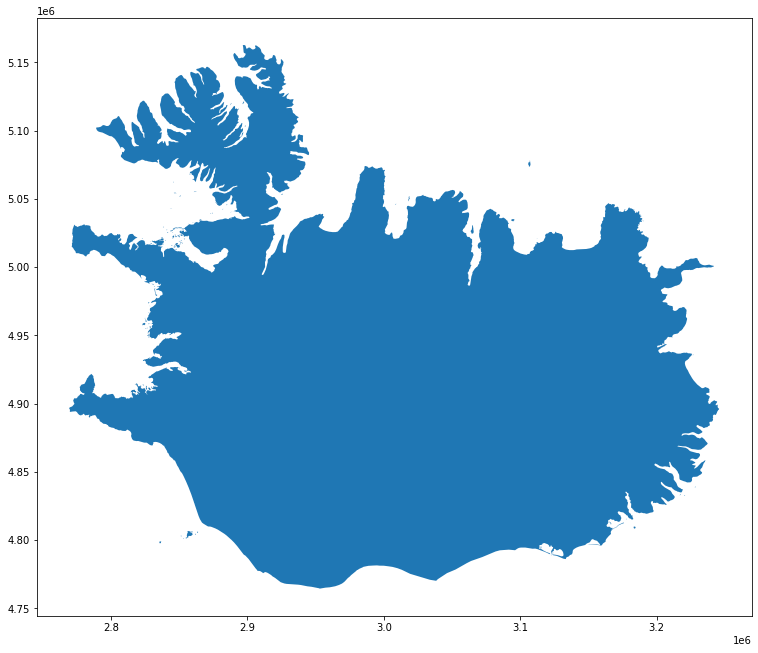

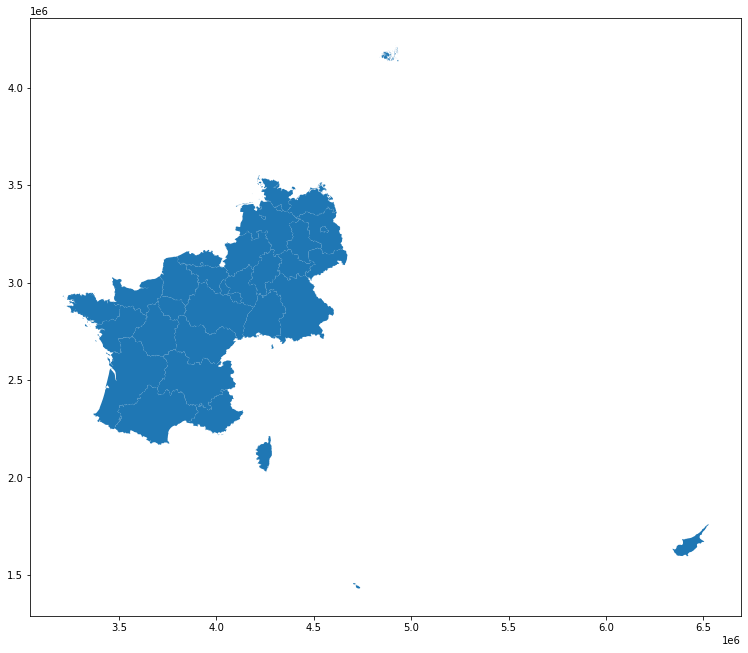

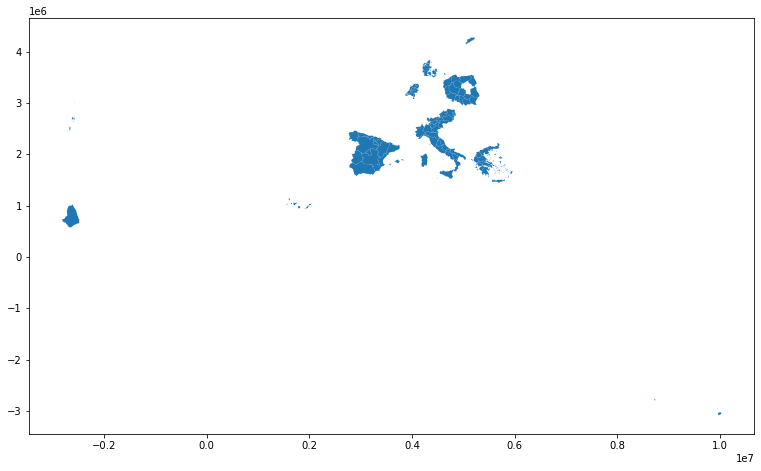

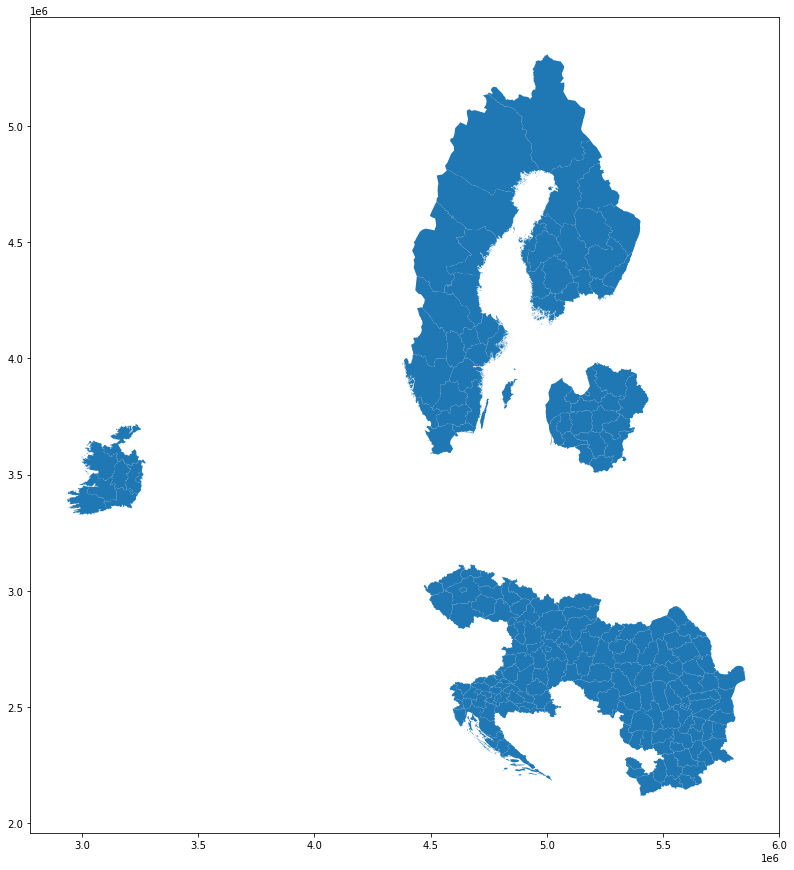

In [41]:
NUTS0_sub.plot(figsize=(13, 11))
plt.show()
NUTS1_sub.plot(figsize=(13, 11))
plt.show()
NUTS2_sub.plot(figsize=(13, 11))
plt.show()
NUTS3_sub.plot(figsize=(14, 15))
plt.show()

In [42]:
everything = NUTS0_sub.append(NUTS1_sub).append(NUTS2_sub).append(NUTS3_sub)

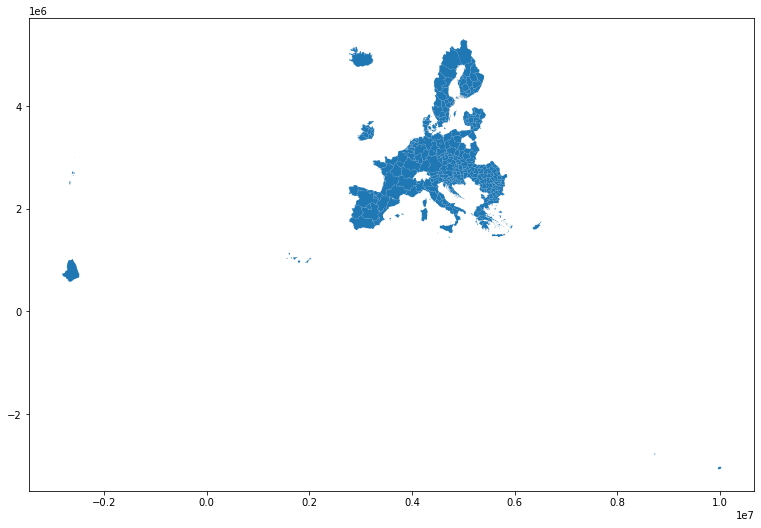

In [43]:
everything.plot(figsize = (13,11))
plt.show()

We can see that there are some non-european areas which we do not want to include. We suspect that they belong to French overseas territories. We have found out on Wikipedia that there are five of these and their FID's begin with "FRY". Thus it is easy to drop them.

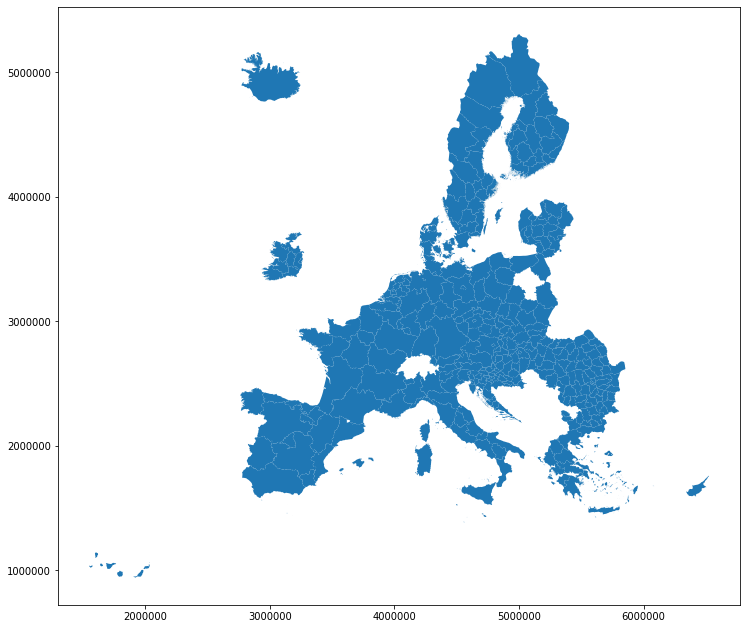

In [99]:
todrop = [l for l in everything['FID'] if l.startswith('FRY')]
everything = everything[-everything['FID'].isin(todrop)]
everything.plot(figsize = (13,11))
plt.show()

Much nicer. There is still some problem because we still cannot see Portugal, Estonia, and part of Poland. Let us see if there is any data for Portugal.

In [104]:
portugal = [l for l in weekly['nuts_code'].unique() if l.startswith('PT')]
portugal

['PTG301', 'PTG302', 'PTG303', 'PTG304', 'PTG305', 'PTG306', 'PTG307']

There seem to be some portuguese regions, but we cannot find these NUTS ID's on the Wikipedia page of portuguese NUTS.

https://en.wikipedia.org/wiki/NUTS_statistical_regions_of_Portugal

Let us see what the names of the regions are.

In [118]:
names = []
for i in portugal:
    names.append(weekly.loc[weekly['nuts_code'] == i,'region_name'].unique()[0])
names

['Alentejo',
 'Algarve',
 'Regiao Autonoma Dos Acores',
 'Centro',
 'Area Metropolitana De Lisboa',
 'Regiao Autonoma Da Madeira',
 'Norte']

So we have data for NUTS2 regions but for some reason their NUTS ID's are different. We shall therefore replace them with the normal ones so they can be matched with the shapefile.

In [128]:
correct_codes = ['PT18', 'PT15', 'PT20', 'PT16', 'PT17', 'PT30', 'PT11']
for i in range(7):
    weekly = weekly.replace({portugal[i]: correct_codes[i]})

Now let us take a look at the problem with Poland.

In [130]:
poland = [l for l in weekly['nuts_code'].unique() if l.startswith('PL')]
poland

['PL21',
 'PL22',
 'PL41',
 'PL42',
 'PL43',
 'PL51',
 'PL52',
 'PL61',
 'PL62',
 'PL63',
 'PL71',
 'PL72',
 'PL81',
 'PL82',
 'PL84',
 'PL92X']

For some reason region PL92 is named PL92X. Let us rename it so it can also be included.

In [135]:
weekly = weekly.replace('PL92X', 'PL92')

Lastly, let us look at Estonia.

In [143]:
eston = [l for l in weekly['nuts_code'].unique() if l.startswith('EE')]
names = []
for i in eston:
    names.append(weekly.loc[weekly['nuts_code'] == i,'region_name'].unique()[0])
names

['Harju Maakond',
 'Hiiu Maakond',
 'Ida-Viru Maakond',
 'Järva Maakond',
 'Jõgeva Maakond',
 'Lääne-Viru Maakond',
 'Lääne Maakond',
 'Pärnu Maakond',
 'Põlva Maakond',
 'Rapla Maakond',
 'Saare Maakond',
 'Tartu Maakond',
 'Valga Maakond',
 'Viljandi Maakond',
 'Võru Maakond']

So here the problem is that Estonia reports data on lower level than NUTS3, for which we have no shapefile. We will therefore omit Estonia from the analysis. Now we generate the combined shapefile again and plot it.

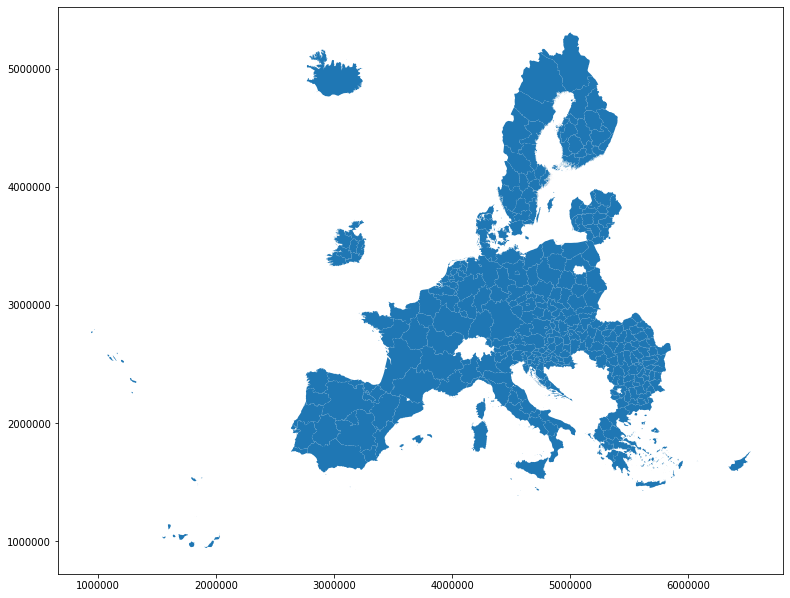

In [165]:
weekly = weekly.replace('BG412X', 'BG412')
NUTS0_sub = NUTS0[NUTS0['FID'].isin(weekly['nuts_code'].unique())]
NUTS1_sub = NUTS1[NUTS1['FID'].isin(weekly['nuts_code'].unique())]
NUTS2_sub = NUTS2[NUTS2['FID'].isin(weekly['nuts_code'].unique())]
NUTS3_sub = NUTS3[NUTS3['FID'].isin(weekly['nuts_code'].unique())]
everything = NUTS0_sub.append(NUTS1_sub).append(NUTS2_sub).append(NUTS3_sub, ignore_index=True)
todrop = [l for l in everything['FID'] if l.startswith('FRY')]
everything = everything[-everything['FID'].isin(todrop)]
everything.plot(figsize = (13,11))
plt.show()

### Visualize country covid cases over time using the shapefile

Because of the discrepancy of data, we choose a few compatible countries on which to do visualization. Four countries that we have complete NUTS3 data for and that are geographically adjacent could be: Hungary, Croatia, Czechia and Slovakia (HU, HR, CZ, SK).

In [44]:
# For all countries in covid dataset store their shapefiles as well
for country in countries.values():
    sf = NUTS3.loc[NUTS3['CNTR_CODE'] == country.code]
    country.set_shapefile(sf)

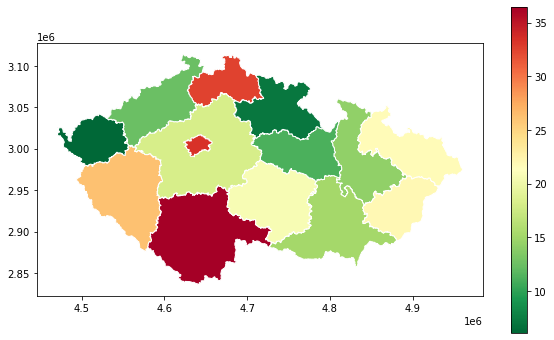

In [45]:
# Plot CZ as an example in a given week
countries['CZ'].plot_country_color_map('2021-24')

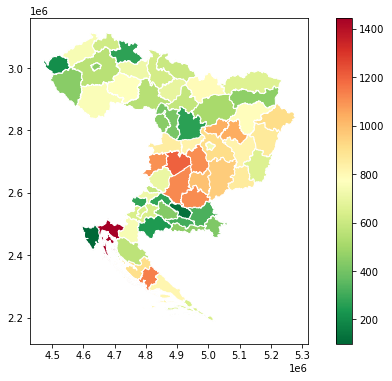

In [47]:
# Plot adjacent countries as mentioned above: Croatia, Czechia, Hungary, and Slovakia
countries_to_plot = ['CZ', 'HU', 'HR', 'SK']
countries_shapefile = NUTS3.loc[NUTS3['CNTR_CODE'].isin(countries_to_plot)]

countries_data = pd.DataFrame()
for c in countries_to_plot:
    df = countries[c].df_nuts_index
    countries_data = countries_data.append(df)

week = '2021-14'
plot_color_map(countries_shapefile, countries_data, week)

In [52]:
# save each weekly map of Czechia in a folder called 'maps'
output_path = 'maps'
filenames = []
country_obj = countries['CZ']
# combine covid dataframe and shapefile dataframe via 'NUTS_ID' index
merged = country_obj.shapefile.set_index('NUTS_ID').join(country_obj.df_nuts_index)
# set the min and max of the data so that the colors are consistent over time
vmin, vmax = country_obj.df_nuts_index.min().min(), country_obj.df_nuts_index.max().max()

# create one map per week for Czechia as an example
for week in countries['CZ'].df.index:
    # create map and add plt.Normalize to keep the legend range the same for all maps
    fig = merged.plot(column=week, cmap='RdYlGn_r', linewidth=1.0, edgecolor='1.0', vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    plt.title("Covid cases per 100k in the year-week: " + week)
    # remove axis of chart
    fig.axis('off')
    # Save figure in the output path
    filepath = os.path.join(output_path, week + '_covid_cases.jpg')
    filenames.append(filepath)
    fig.get_figure().savefig(filepath, dpi=300)
    # clear the figure to save memory
    plt.close()
    gc.collect()

In [53]:
# Create a gif with the images saved above
with imageio.get_writer('colormap.gif', mode='I', fps=2) as writer:
    for fn in filenames:
        colormap = imageio.imread(fn)
        writer.append_data(colormap)

![ColorMap](colormap.gif "colormap")

## 4 Generate weight matrix

In [166]:
from pysal.lib import weights
wq =  weights.distance.KNN.from_dataframe(everything, k=4)

C:\ProgramData\Anaconda3\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


## 5 Calculate Moran's I from the data and the matrix

In [193]:
nuts_code_index = weekly.pivot(index='nuts_code', columns='year_week', values='rate_14_day_per_100k')
fids = everything['FID'].unique()
rows = [n for n, l in enumerate(list(nuts_code_index.index)) if l in fids]
mi = []
for i in nuts_code_index.columns:
    y = nuts_code_index[i][rows]
    y = y.fillna(value=0)
    mi.append(esda.moran.Moran(y, wq))
results = []
for i in mi:
    results.append(i.I)

C:\ProgramData\Anaconda3\lib\site-packages\esda\moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
C:\ProgramData\Anaconda3\lib\site-packages\esda\moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
C:\ProgramData\Anaconda3\lib\site-packages\esda\moran.py:185: RuntimeWarning: invalid value encountered in greater_equal
  above = sim >= self.I
C:\ProgramData\Anaconda3\lib\site-packages\e

## 6 Visualize Moran's I time series

Here we will visualize the Moran's I time series in a plot. We don't have the series yet, so let's generate a random one for now and visualize it and then at the end, when the series is finally obtained, we will just substitute it in the plot.

In [195]:
y = pd.DataFrame(results)

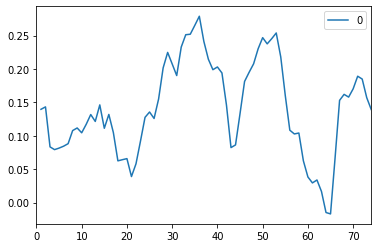

In [198]:
#make a plot of y:
y.plot()
plt.show()